<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телескоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [5]:
# read data
names = np.array(
    [
        "Length", 
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [6]:
# параметры кластеров на изображениях
X = data[names[:-1]].values 
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [7]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [8]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [9]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [10]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

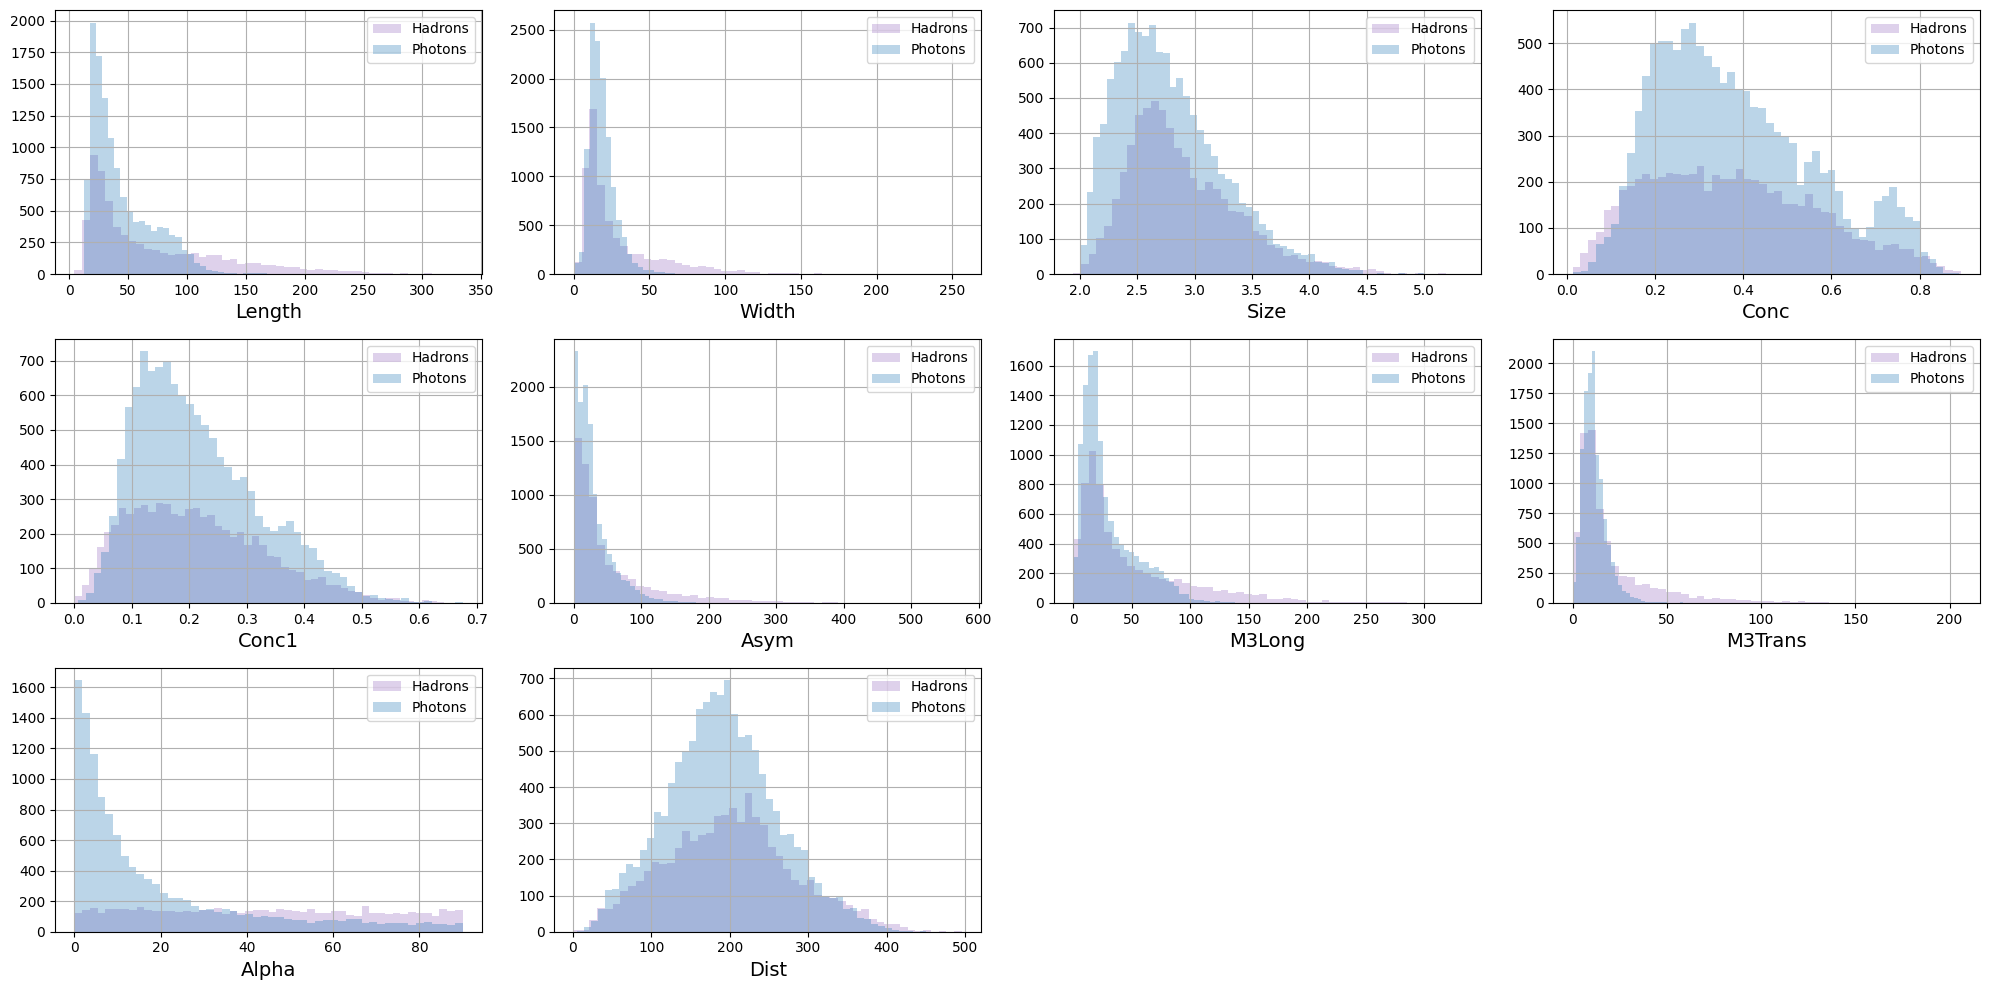

In [11]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее...
```Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.```

# Обучающая и тестовая выборки

In [12]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение целевой переменной внутри train и test выборки. Совпадает ли оно? Есть ли идеи почему так?

__Подсказка__: посмотрите на клеточку с разделением данных

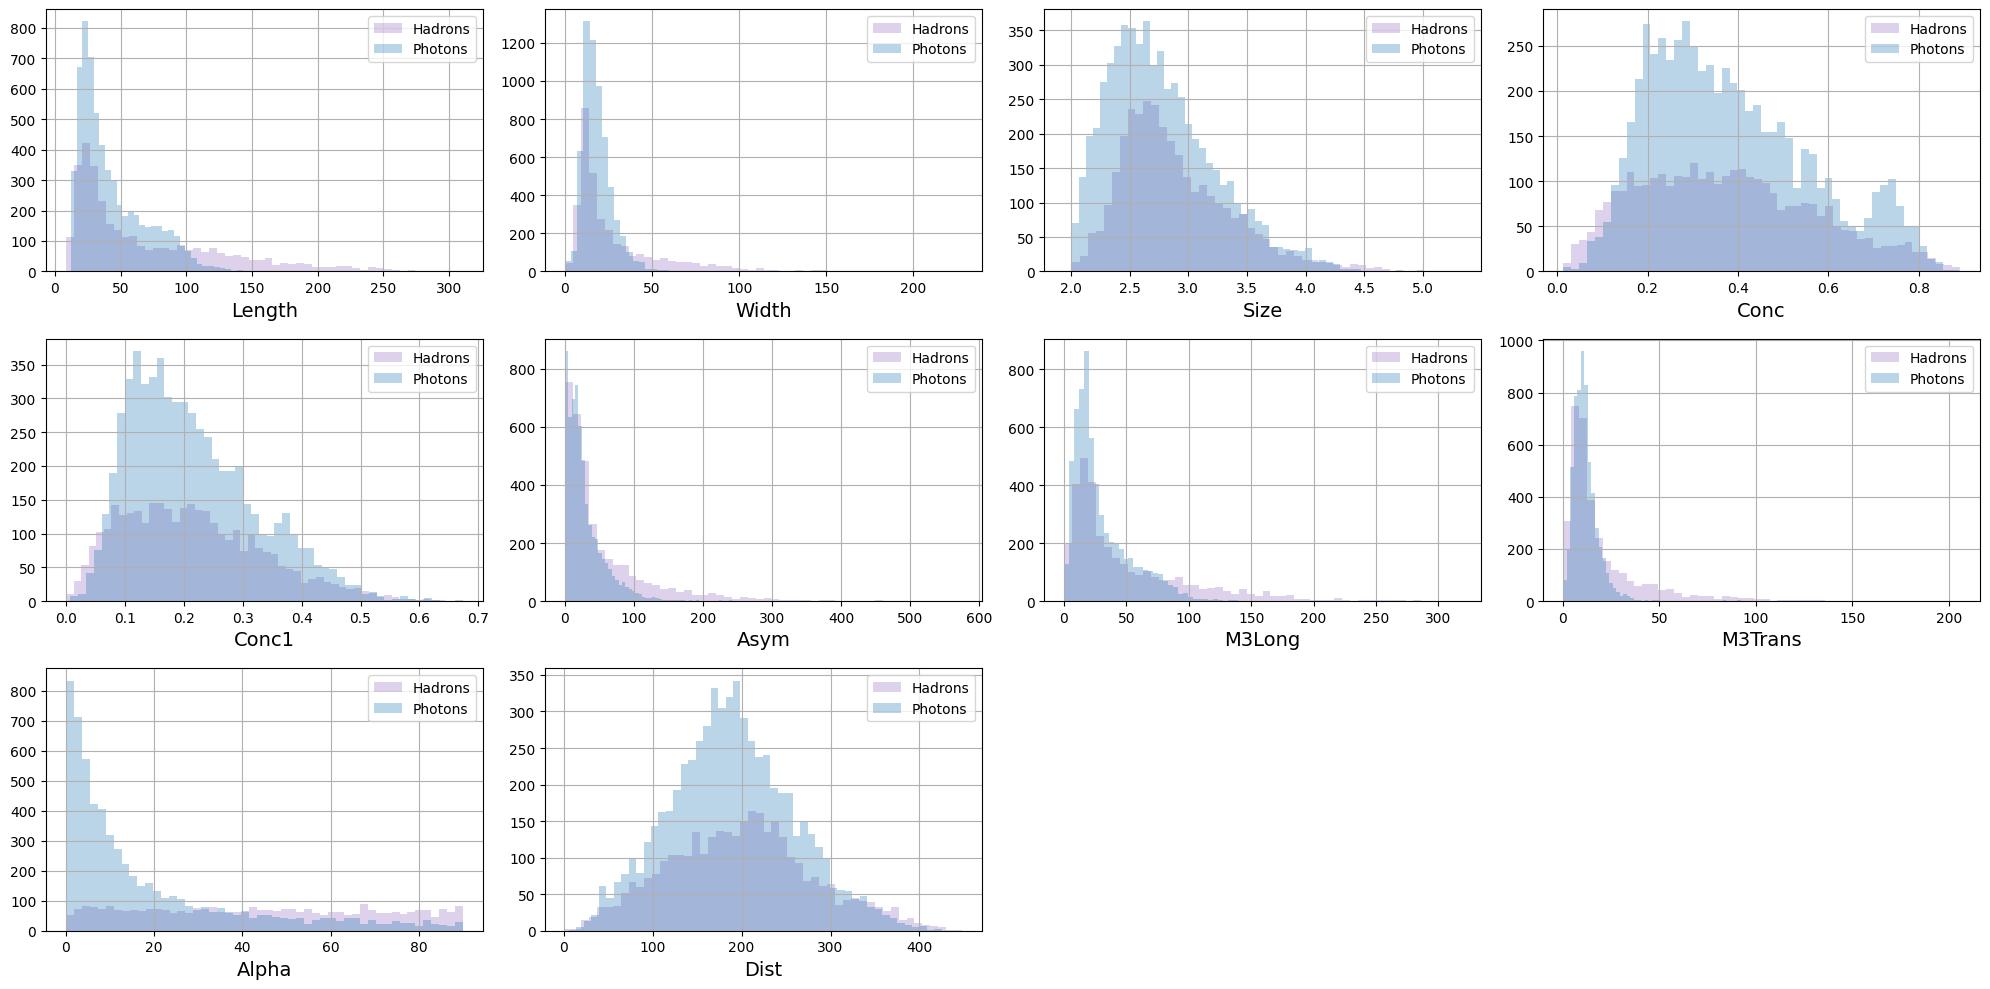

In [13]:
plot_hists(
    X_train[y_train[:, 0] == 0], 
    X_train[y_train[:, 0] == 1], 
    names, label1="Hadrons", label2="Photons", bins=50
)

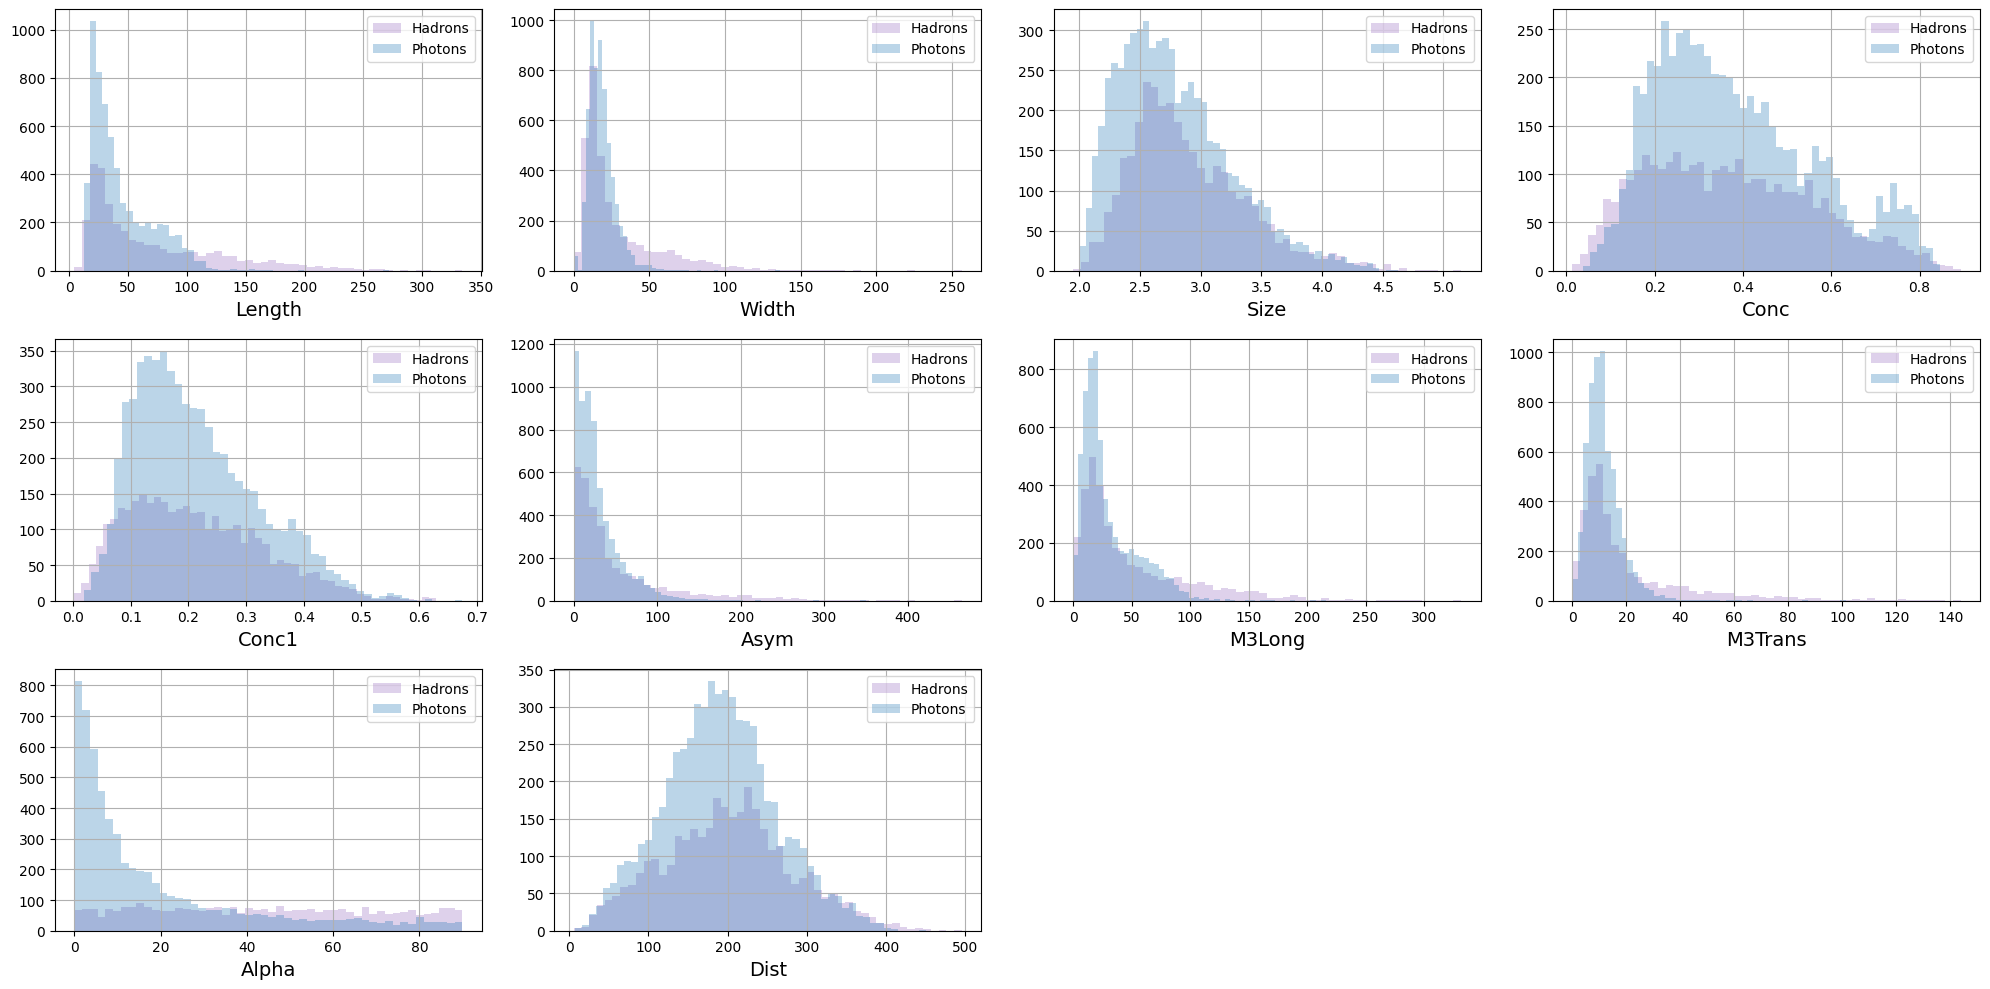

In [14]:
plot_hists(
    X_test[y_test[:, 0] == 0], 
    X_test[y_test[:, 0] == 1], 
    names, label1="Hadrons", label2="Photons", bins=50
)


## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [15]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=11)

X_train_normal = quantile_transformer.fit_transform(X_train)
X_test_normal = quantile_transformer.transform(X_test)

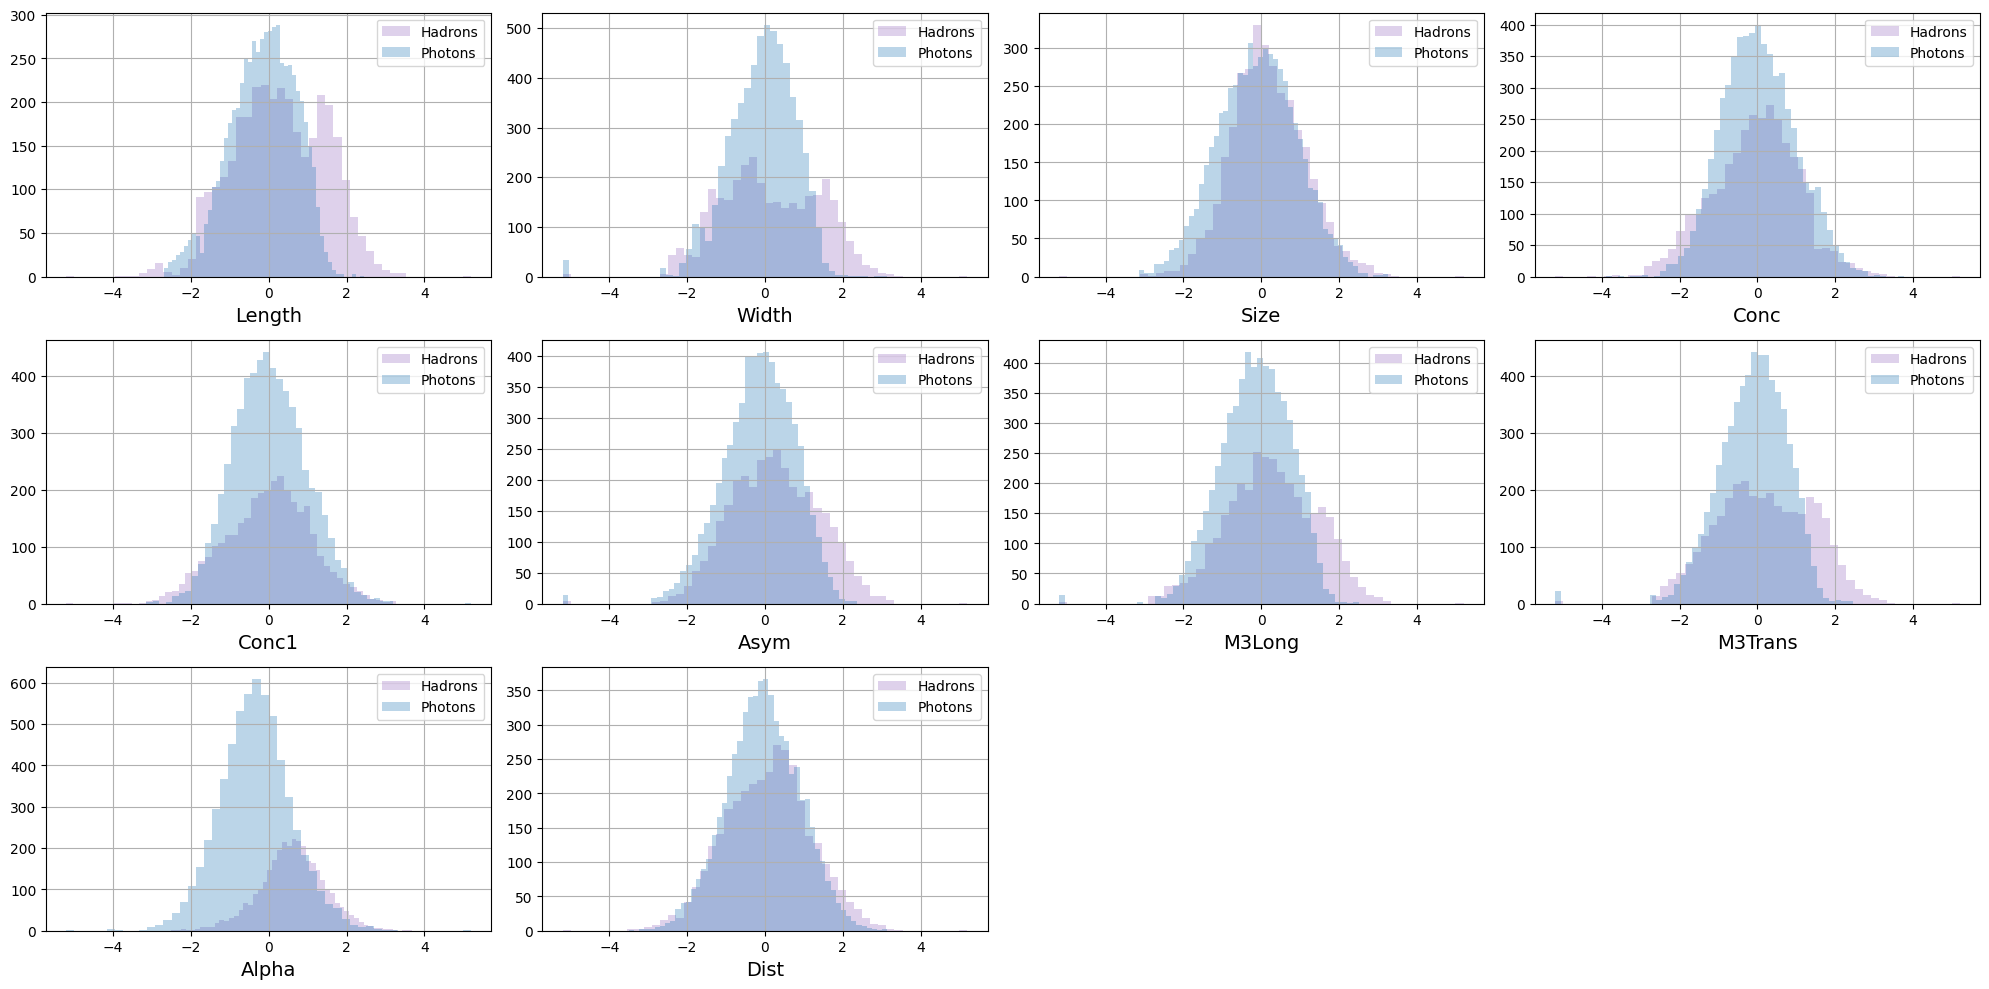

In [16]:
plot_hists(
    X_train_normal[y_train[:, 0] == 0],
    X_train_normal[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

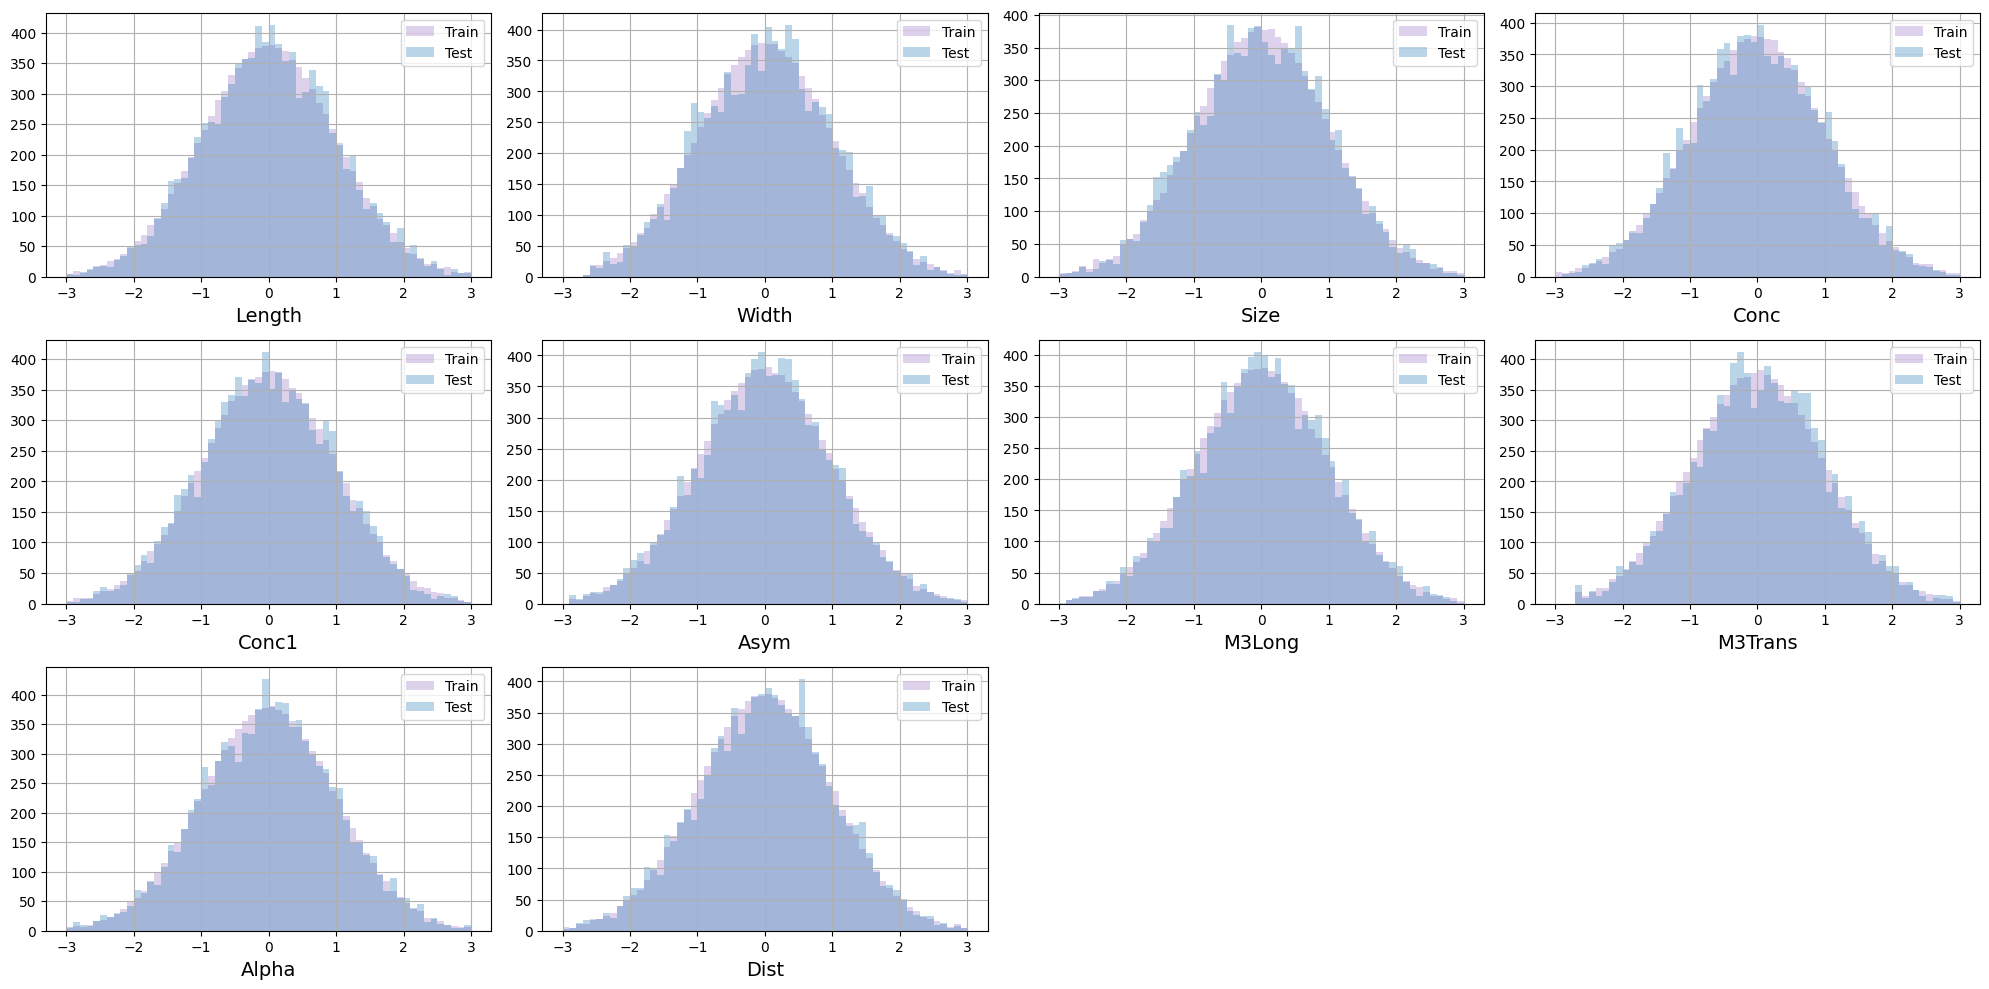

In [17]:
plot_hists(X_train_normal, X_test_normal, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

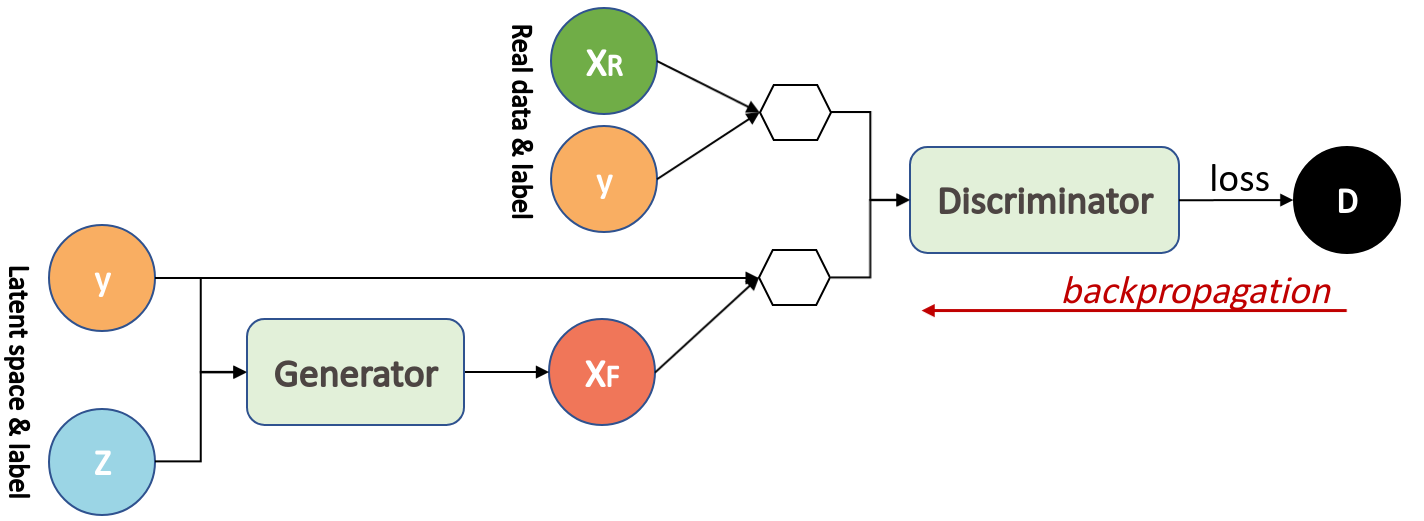

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [61]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        
        ### YOUR CODE IS HERE ######
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )
        ### THE END OF YOUR CODE ###
        
    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.model(zy)


## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [62]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######
    z = torch.normal(mean=0, std=1, size=(y.shape[0], latent_dim), device=DEVICE)  # Генерируем z из нормального распределения
    y_tensor = torch.tensor(y, dtype=torch.float, device=DEVICE)  # Преобразуем y в тензор
    with torch.no_grad():  # Отключаем градиенты
        X_fake = generator(z, y_tensor).detach().cpu().numpy()
    ### THE END OF YOUR CODE ###
    return X_fake


## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [63]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        ### YOUR CODE IS HERE ######
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
        ### THE END OF YOUR CODE ###
        
    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.model(xy)


> В WGAN выходной слой дискриминатора должен быть скалярным, без применения сигмоиды или других активаций. Это отличие от стандартного GAN, где дискриминатор использует сигмоидную функцию для вывода вероятности.

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def other_agent_score(X_real, y_real, X_fake, y_fake):
    ### YOUR CODE IS HERE ######
    fake = torch.tensor([0]).repeat(y_fake.shape[0], 1)
    real = torch.tensor([1]).repeat(y_real.shape[0], 1)
    y = torch.cat((real, fake), dim=0).cpu().detach().numpy() # Собираем метки классов
    
    Xyr = torch.cat((X_real, y_real), dim=1) # набор настоящих объектов
    Xyf = torch.cat((X_fake, y_fake), dim=1) # набор сгенерированных объектов
    Xy = torch.cat((Xyr, Xyf), dim=0).cpu().detach().numpy() # набор и сгенерированных и настоящих объектов
    
    X_train, X_test, y_train, y_test = train_test_split(Xy, y, stratify=y, test_size=0.5, shuffle=True, random_state=11)
    
    lr = LogisticRegression(random_state=11).fit(X_train, y_train)
    lin_reg_score = accuracy_score(y_test, lr.predict(X_test))
    
    gbc = GradientBoostingClassifier(random_state=11).fit(X_train, y_train)
    boosting_score = accuracy_score(y_test, gbc.predict(X_test))
    ### THE END OF YOUR CODE ###
    
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [65]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in tqdm.tqdm(range(self.n_epochs)):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                # Обучение дискриминатора
                self.opt_disc.zero_grad()
                
                z_noise = torch.normal(0, 1, (real_batch.size(0), self.latent_dim), device=DEVICE)
                fake_batch = self.generator(z_noise, cond_batch)
                
                disc_real = self.discriminator(real_batch, cond_batch)
                disc_fake = self.discriminator(fake_batch.detach(), cond_batch)
                
                loss_disc = -(torch.mean(disc_real) - torch.mean(disc_fake))
                loss_disc.backward()
                self.opt_disc.step()

                # Ограничение весов дискриминатора (особенность WGAN)
                for p in self.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
                
                # Обучение генератора раз в n_critic итераций
                if i % self.n_critic == 0:
                    self.opt_gen.zero_grad()
                    gen_fake = self.discriminator(fake_batch, cond_batch)
                    loss_gen = -torch.mean(gen_fake)
                    loss_gen.backward()
                    self.opt_gen.step()
                
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            i = torch.randint(1, len(X_real), (1000,))
            X_r = X_real[i]  
            X_f = X_fake[i]
            other_agent_score(X_r, y_cond[i], X_f, y_cond[i])
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [ ]:
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train_normal.shape[1])
discriminator = Discriminator(n_inputs=X_train_normal.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train_normal, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  1%|          | 1/100 [00:01<03:14,  1.96s/it]

Linear regression score: 0.534
Boosting score: 0.87


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  2%|▏         | 2/100 [00:03<02:51,  1.75s/it]

Linear regression score: 0.562
Boosting score: 0.851


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  3%|▎         | 3/100 [00:05<02:45,  1.71s/it]

Linear regression score: 0.559
Boosting score: 0.809


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  4%|▍         | 4/100 [00:06<02:41,  1.68s/it]

Linear regression score: 0.521
Boosting score: 0.75


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  5%|▌         | 5/100 [00:08<02:35,  1.64s/it]

Linear regression score: 0.558
Boosting score: 0.72


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  6%|▌         | 6/100 [00:09<02:18,  1.47s/it]

Linear regression score: 0.519
Boosting score: 0.703


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  7%|▋         | 7/100 [00:10<02:08,  1.38s/it]

Linear regression score: 0.499
Boosting score: 0.677


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  8%|▊         | 8/100 [00:11<02:01,  1.32s/it]

Linear regression score: 0.524
Boosting score: 0.671


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  9%|▉         | 9/100 [00:13<01:54,  1.26s/it]

Linear regression score: 0.475
Boosting score: 0.674


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 10%|█         | 10/100 [00:14<01:49,  1.22s/it]

Linear regression score: 0.494
Boosting score: 0.68


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 11%|█         | 11/100 [00:15<01:48,  1.22s/it]

Linear regression score: 0.532
Boosting score: 0.671


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 12%|█▏        | 12/100 [00:16<01:44,  1.19s/it]

Linear regression score: 0.509
Boosting score: 0.657


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 13%|█▎        | 13/100 [00:17<01:41,  1.17s/it]

Linear regression score: 0.502
Boosting score: 0.674


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 14%|█▍        | 14/100 [00:18<01:39,  1.16s/it]

Linear regression score: 0.539
Boosting score: 0.682


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 15%|█▌        | 15/100 [00:19<01:38,  1.16s/it]

Linear regression score: 0.544
Boosting score: 0.666


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 16%|█▌        | 16/100 [00:21<01:36,  1.15s/it]

Linear regression score: 0.517
Boosting score: 0.654


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 17%|█▋        | 17/100 [00:22<01:35,  1.15s/it]

Linear regression score: 0.498
Boosting score: 0.668


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 18%|█▊        | 18/100 [00:23<01:33,  1.14s/it]

Linear regression score: 0.523
Boosting score: 0.666


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 19%|█▉        | 19/100 [00:24<01:32,  1.14s/it]

Linear regression score: 0.592
Boosting score: 0.673


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 20%|██        | 20/100 [00:25<01:31,  1.15s/it]

Linear regression score: 0.592
Boosting score: 0.651


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 21%|██        | 21/100 [00:26<01:29,  1.14s/it]

Linear regression score: 0.596
Boosting score: 0.686


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 22%|██▏       | 22/100 [00:27<01:28,  1.14s/it]

Linear regression score: 0.589
Boosting score: 0.627


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 23%|██▎       | 23/100 [00:29<01:27,  1.14s/it]

Linear regression score: 0.56
Boosting score: 0.629


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 24%|██▍       | 24/100 [00:30<01:26,  1.14s/it]

Linear regression score: 0.528
Boosting score: 0.623


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 25%|██▌       | 25/100 [00:31<01:25,  1.15s/it]

Linear regression score: 0.541
Boosting score: 0.64


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 26%|██▌       | 26/100 [00:32<01:24,  1.14s/it]

Linear regression score: 0.524
Boosting score: 0.602


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 27%|██▋       | 27/100 [00:33<01:25,  1.17s/it]

Linear regression score: 0.496
Boosting score: 0.648


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 28%|██▊       | 28/100 [00:34<01:23,  1.16s/it]

Linear regression score: 0.527
Boosting score: 0.647


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 29%|██▉       | 29/100 [00:36<01:22,  1.17s/it]

Linear regression score: 0.513
Boosting score: 0.606


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 30%|███       | 30/100 [00:37<01:22,  1.18s/it]

Linear regression score: 0.564
Boosting score: 0.627


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 31%|███       | 31/100 [00:38<01:21,  1.19s/it]

Linear regression score: 0.52
Boosting score: 0.607


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 32%|███▏      | 32/100 [00:39<01:19,  1.17s/it]

Linear regression score: 0.522
Boosting score: 0.628


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 33%|███▎      | 33/100 [00:40<01:17,  1.15s/it]

Linear regression score: 0.526
Boosting score: 0.613


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 34%|███▍      | 34/100 [00:41<01:15,  1.15s/it]

Linear regression score: 0.498
Boosting score: 0.591


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 35%|███▌      | 35/100 [00:43<01:17,  1.19s/it]

Linear regression score: 0.513
Boosting score: 0.577


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 36%|███▌      | 36/100 [00:44<01:15,  1.18s/it]

Linear regression score: 0.502
Boosting score: 0.602


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 37%|███▋      | 37/100 [00:45<01:13,  1.17s/it]

Linear regression score: 0.511
Boosting score: 0.572


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 38%|███▊      | 38/100 [00:46<01:12,  1.16s/it]

Linear regression score: 0.494
Boosting score: 0.583


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 39%|███▉      | 39/100 [00:47<01:11,  1.17s/it]

Linear regression score: 0.505
Boosting score: 0.597


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 40%|████      | 40/100 [00:48<01:09,  1.17s/it]

Linear regression score: 0.548
Boosting score: 0.601


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 41%|████      | 41/100 [00:50<01:08,  1.16s/it]

Linear regression score: 0.5
Boosting score: 0.591


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 42%|████▏     | 42/100 [00:51<01:06,  1.15s/it]

Linear regression score: 0.502
Boosting score: 0.581


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 43%|████▎     | 43/100 [00:52<01:05,  1.15s/it]

Linear regression score: 0.544
Boosting score: 0.565


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 44%|████▍     | 44/100 [00:53<01:04,  1.15s/it]

Linear regression score: 0.51
Boosting score: 0.579


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 45%|████▌     | 45/100 [00:54<01:02,  1.14s/it]

Linear regression score: 0.504
Boosting score: 0.558


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 46%|████▌     | 46/100 [00:55<01:01,  1.14s/it]

Linear regression score: 0.509
Boosting score: 0.567


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 47%|████▋     | 47/100 [00:56<00:59,  1.13s/it]

Linear regression score: 0.483
Boosting score: 0.584


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 48%|████▊     | 48/100 [00:57<00:58,  1.13s/it]

Linear regression score: 0.515
Boosting score: 0.579


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 49%|████▉     | 49/100 [00:59<00:57,  1.12s/it]

Linear regression score: 0.536
Boosting score: 0.572


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 50%|█████     | 50/100 [01:00<00:56,  1.13s/it]

Linear regression score: 0.528
Boosting score: 0.633


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 51%|█████     | 51/100 [01:01<00:55,  1.13s/it]

Linear regression score: 0.548
Boosting score: 0.582


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 52%|█████▏    | 52/100 [01:02<00:54,  1.14s/it]

Linear regression score: 0.51
Boosting score: 0.571


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 53%|█████▎    | 53/100 [01:03<00:53,  1.15s/it]

Linear regression score: 0.519
Boosting score: 0.547


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 54%|█████▍    | 54/100 [01:04<00:52,  1.15s/it]

Linear regression score: 0.553
Boosting score: 0.594


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 55%|█████▌    | 55/100 [01:06<00:53,  1.19s/it]

Linear regression score: 0.53
Boosting score: 0.592


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 56%|█████▌    | 56/100 [01:07<00:52,  1.18s/it]

Linear regression score: 0.521
Boosting score: 0.578


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 57%|█████▋    | 57/100 [01:08<00:51,  1.19s/it]

Linear regression score: 0.574
Boosting score: 0.58


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 58%|█████▊    | 58/100 [01:09<00:50,  1.19s/it]

Linear regression score: 0.504
Boosting score: 0.549


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 59%|█████▉    | 59/100 [01:10<00:48,  1.19s/it]

Linear regression score: 0.495
Boosting score: 0.576


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 60%|██████    | 60/100 [01:12<00:48,  1.20s/it]

Linear regression score: 0.556
Boosting score: 0.566


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 61%|██████    | 61/100 [01:13<00:46,  1.20s/it]

Linear regression score: 0.514
Boosting score: 0.581


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 62%|██████▏   | 62/100 [01:14<00:44,  1.18s/it]

Linear regression score: 0.576
Boosting score: 0.595


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 63%|██████▎   | 63/100 [01:15<00:43,  1.19s/it]

Linear regression score: 0.484
Boosting score: 0.561


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 64%|██████▍   | 64/100 [01:16<00:42,  1.17s/it]

Linear regression score: 0.559
Boosting score: 0.601


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 65%|██████▌   | 65/100 [01:17<00:40,  1.17s/it]

Linear regression score: 0.51
Boosting score: 0.587


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 66%|██████▌   | 66/100 [01:19<00:39,  1.16s/it]

Linear regression score: 0.53
Boosting score: 0.553


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 67%|██████▋   | 67/100 [01:20<00:38,  1.15s/it]

Linear regression score: 0.52
Boosting score: 0.566


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 68%|██████▊   | 68/100 [01:21<00:36,  1.15s/it]

Linear regression score: 0.545
Boosting score: 0.563


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 69%|██████▉   | 69/100 [01:22<00:36,  1.17s/it]

Linear regression score: 0.5
Boosting score: 0.57


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 70%|███████   | 70/100 [01:23<00:34,  1.17s/it]

Linear regression score: 0.558
Boosting score: 0.589


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 71%|███████   | 71/100 [01:24<00:33,  1.16s/it]

Linear regression score: 0.518
Boosting score: 0.576


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 72%|███████▏  | 72/100 [01:26<00:32,  1.16s/it]

Linear regression score: 0.486
Boosting score: 0.574


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 73%|███████▎  | 73/100 [01:27<00:31,  1.17s/it]

Linear regression score: 0.498
Boosting score: 0.539


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 74%|███████▍  | 74/100 [01:28<00:30,  1.17s/it]

Linear regression score: 0.541
Boosting score: 0.567


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 75%|███████▌  | 75/100 [01:29<00:29,  1.16s/it]

Linear regression score: 0.52
Boosting score: 0.562


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 76%|███████▌  | 76/100 [01:30<00:28,  1.17s/it]

Linear regression score: 0.524
Boosting score: 0.585


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 77%|███████▋  | 77/100 [01:31<00:26,  1.17s/it]

Linear regression score: 0.515
Boosting score: 0.57


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 78%|███████▊  | 78/100 [01:33<00:25,  1.18s/it]

Linear regression score: 0.548
Boosting score: 0.569


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 79%|███████▉  | 79/100 [01:34<00:24,  1.18s/it]

Linear regression score: 0.494
Boosting score: 0.541


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 80%|████████  | 80/100 [01:35<00:23,  1.19s/it]

Linear regression score: 0.554
Boosting score: 0.581


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 81%|████████  | 81/100 [01:36<00:22,  1.18s/it]

Linear regression score: 0.523
Boosting score: 0.55


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 82%|████████▏ | 82/100 [01:37<00:21,  1.18s/it]

Linear regression score: 0.555
Boosting score: 0.564


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 83%|████████▎ | 83/100 [01:38<00:19,  1.16s/it]

Linear regression score: 0.522
Boosting score: 0.562


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 84%|████████▍ | 84/100 [01:40<00:18,  1.17s/it]

Linear regression score: 0.529
Boosting score: 0.566


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 85%|████████▌ | 85/100 [01:41<00:17,  1.17s/it]

Linear regression score: 0.513
Boosting score: 0.556


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 86%|████████▌ | 86/100 [01:42<00:16,  1.16s/it]

Linear regression score: 0.557
Boosting score: 0.541


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 87%|████████▋ | 87/100 [01:43<00:15,  1.17s/it]

Linear regression score: 0.542
Boosting score: 0.555


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 88%|████████▊ | 88/100 [01:44<00:14,  1.17s/it]

Linear regression score: 0.56
Boosting score: 0.558


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 89%|████████▉ | 89/100 [01:46<00:12,  1.18s/it]

Linear regression score: 0.535
Boosting score: 0.599


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 90%|█████████ | 90/100 [01:47<00:11,  1.17s/it]

Linear regression score: 0.529
Boosting score: 0.563


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 91%|█████████ | 91/100 [01:48<00:10,  1.18s/it]

Linear regression score: 0.546
Boosting score: 0.573


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 92%|█████████▏| 92/100 [01:49<00:09,  1.16s/it]

Linear regression score: 0.531
Boosting score: 0.587


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 93%|█████████▎| 93/100 [01:50<00:08,  1.17s/it]

Linear regression score: 0.59
Boosting score: 0.563


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 94%|█████████▍| 94/100 [01:51<00:06,  1.15s/it]

Linear regression score: 0.556
Boosting score: 0.547


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 95%|█████████▌| 95/100 [01:52<00:05,  1.16s/it]

Linear regression score: 0.517
Boosting score: 0.597


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 96%|█████████▌| 96/100 [01:54<00:04,  1.16s/it]

Linear regression score: 0.576
Boosting score: 0.59


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 97%|█████████▋| 97/100 [01:55<00:03,  1.18s/it]

Linear regression score: 0.504
Boosting score: 0.549


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 98%|█████████▊| 98/100 [01:56<00:02,  1.17s/it]

Linear regression score: 0.505
Boosting score: 0.573


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 99%|█████████▉| 99/100 [01:57<00:01,  1.17s/it]

Linear regression score: 0.519
Boosting score: 0.551


d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\HSE\IAD\ADS\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 100/100 [01:58<00:00,  1.19s/it]

Linear regression score: 0.494
Boosting score: 0.565


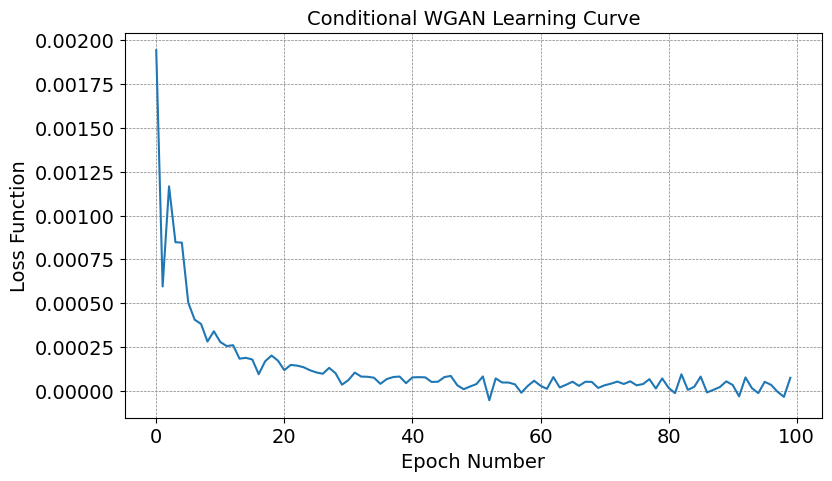

In [68]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [69]:
### YOUR CODE IS HERE ######
X_train = quantile_transformer.inverse_transform(X_train_normal)
X_test = quantile_transformer.inverse_transform(X_test_normal)
### THE END OF YOUR CODE ###

In [70]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = quantile_transformer.inverse_transform(X_fake_train)

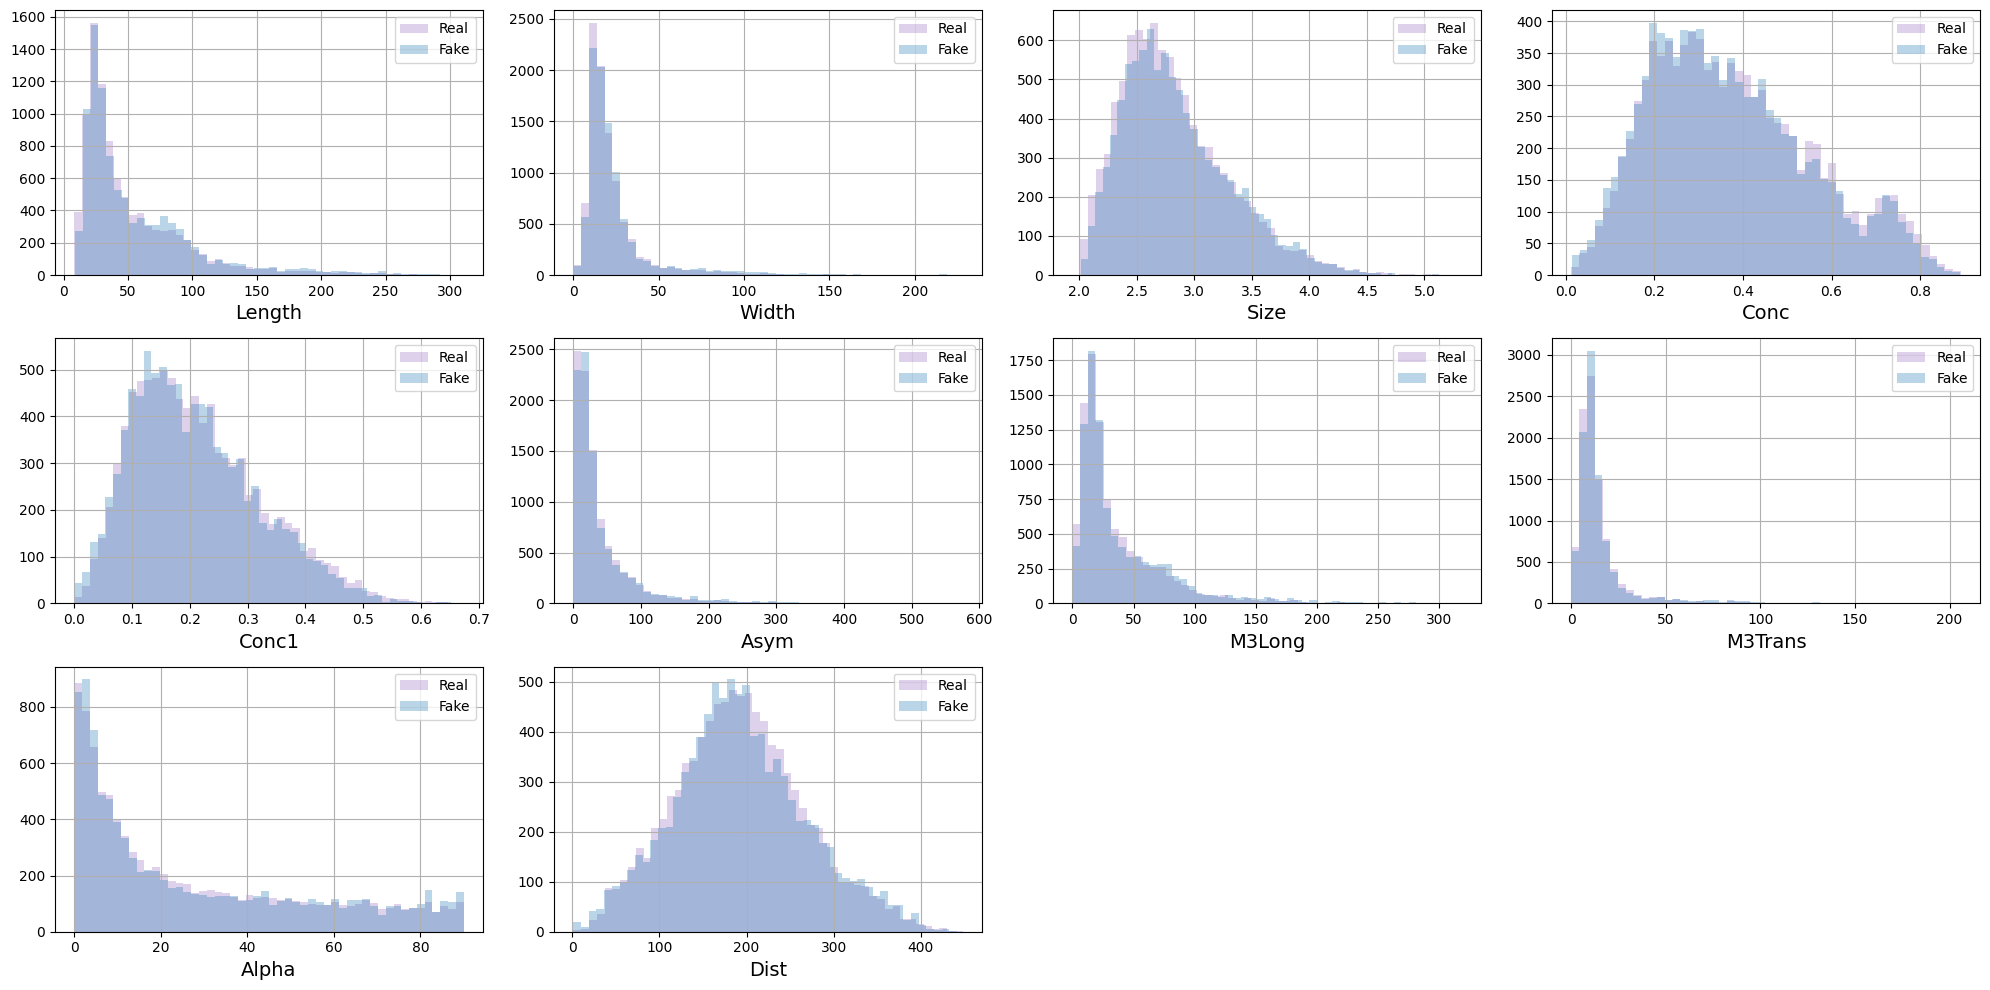

In [71]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [72]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = quantile_transformer.inverse_transform(X_fake_test)

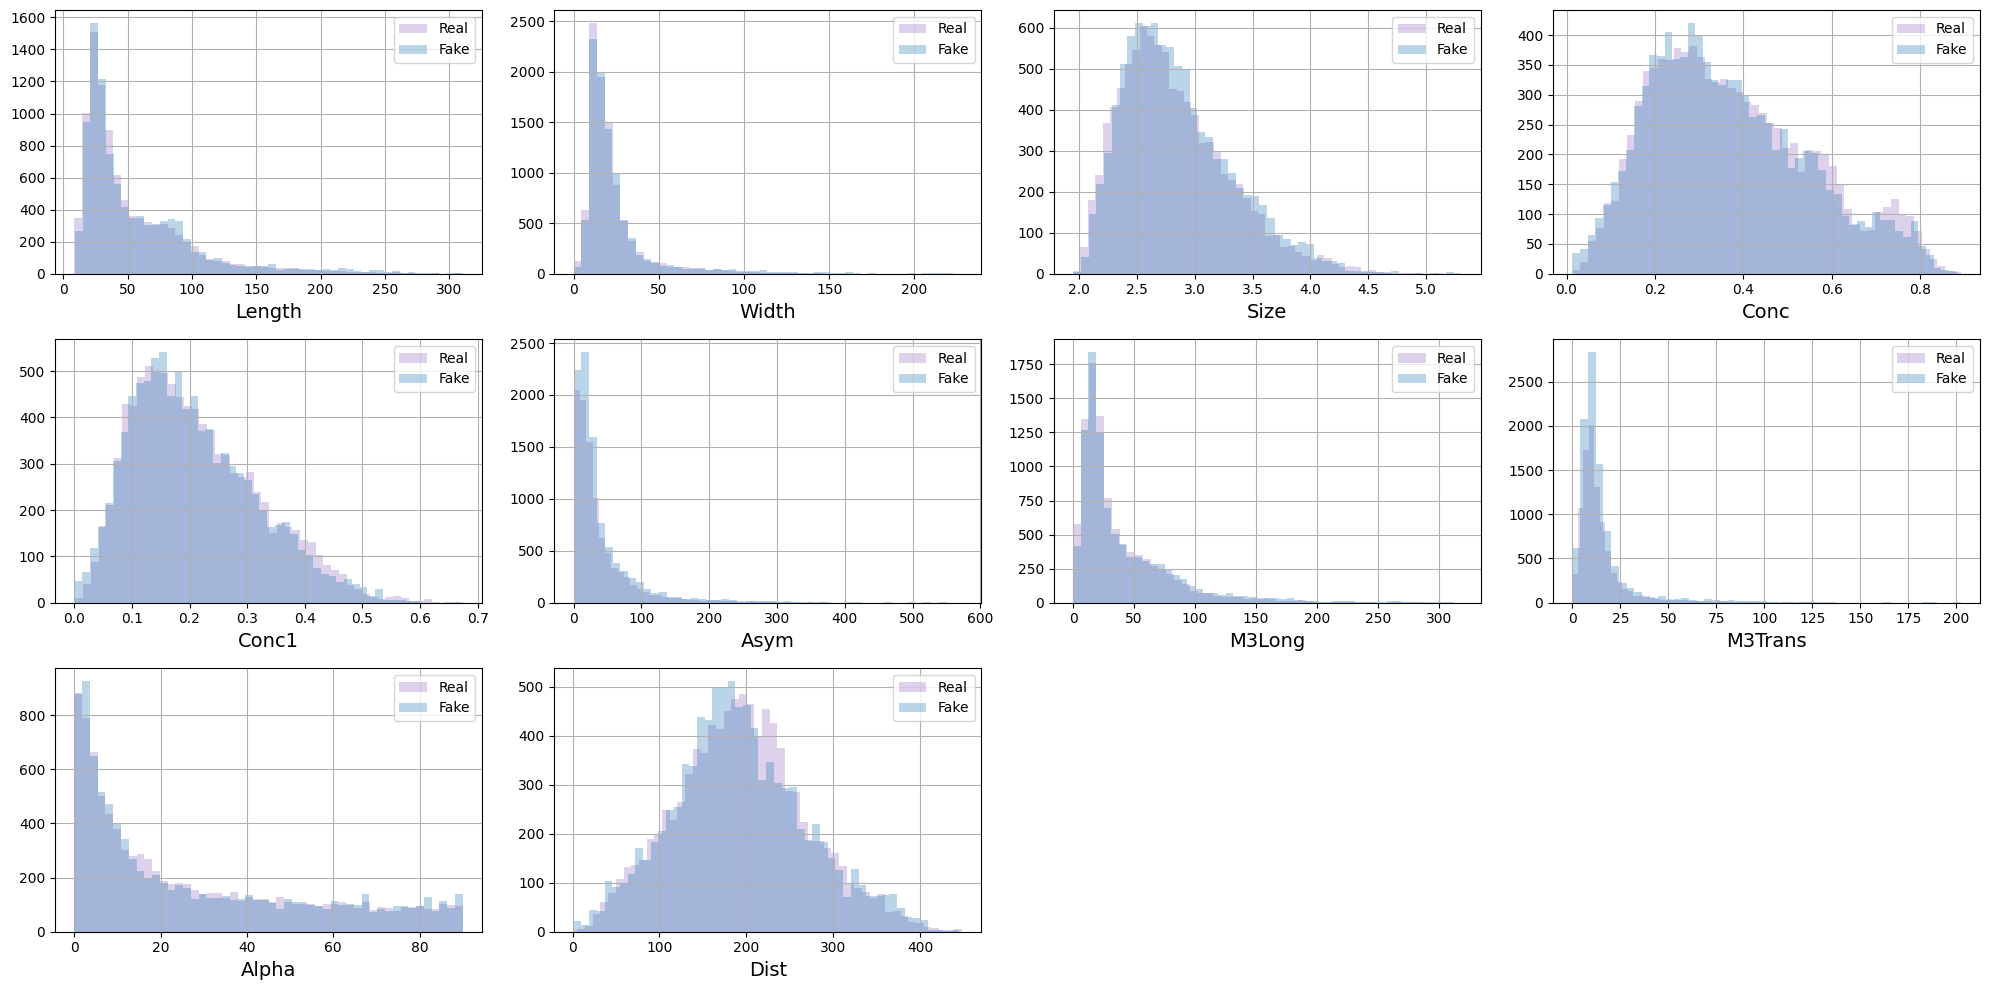

In [73]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Ответьте на вопросы: 
- Похожи ли фейковые объекты на реальные? 
- Точно ли хорошая идея сравнивать их на глаз?


- Да, очень даже неплохо
- Да, глаза - обучаемый уже 20 лет классфикатор
(ну для 2д/3д данных, конечно)

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

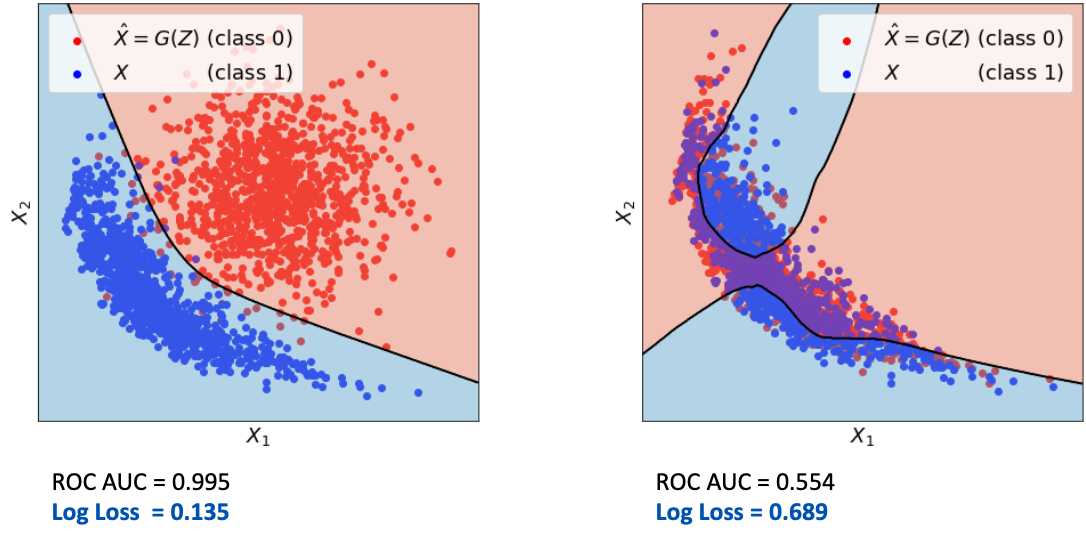

In [74]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [75]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [76]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6803713286473589


с сигмоидой на выходе 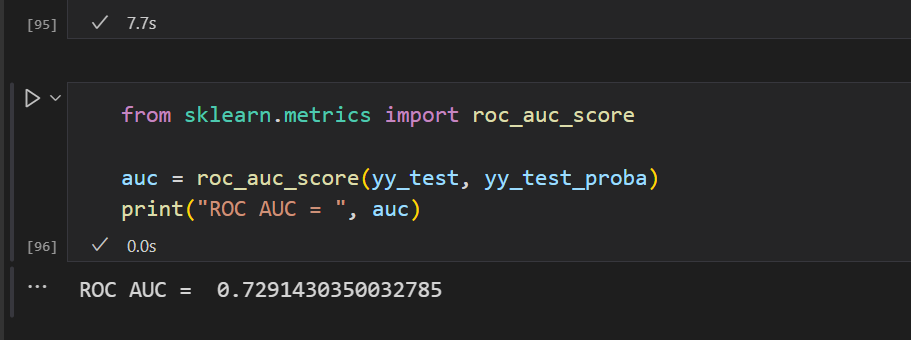

## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


> Реализованная модель WGAN неплохо справилась с задачей. Лучший рок аук конечно 0.5, когда классификатор не может отличить тру от псевдо. Но 0.68 тоже неплохо.
Иронично что добавление сигмоиды выдавало результат 0.7 +- 0.02 где-то

# Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Воспользуйтесь [DDPMScheduler](https://huggingface.co/docs/diffusers/api/schedulers/ddpm), возьмите 1000 шагов и подумайте, надо ли указать ещё какой-то параметр.

__Подсказка__: Посмотрите на распределения выше и почитайте описание шедулера в документации. Один из параметров - наследие от использования в генерации картинок, а у нас не картинки.

In [164]:
!pip install diffusers

  Using cached regex-2024.11.6-cp312-cp312-win_amd64.whl.metadata (41 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached charset_normalizer-3.4.1-cp312-cp312-win_amd64.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------

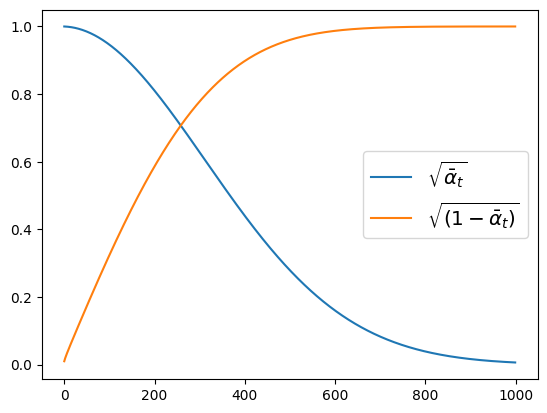

In [18]:
from diffusers import DDPMScheduler
import torch.nn as nn

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качестве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [138]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, t, y):
        ### YOUR CODE IS HERE ######
        t = t.view(-1, 1) # Преобразуем t в тензор для корректной конкатенации.
        zy = torch.cat((z, t, y), dim=1)
        return self.model(zy)
        ### THE END OF YOUR CODE ###

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

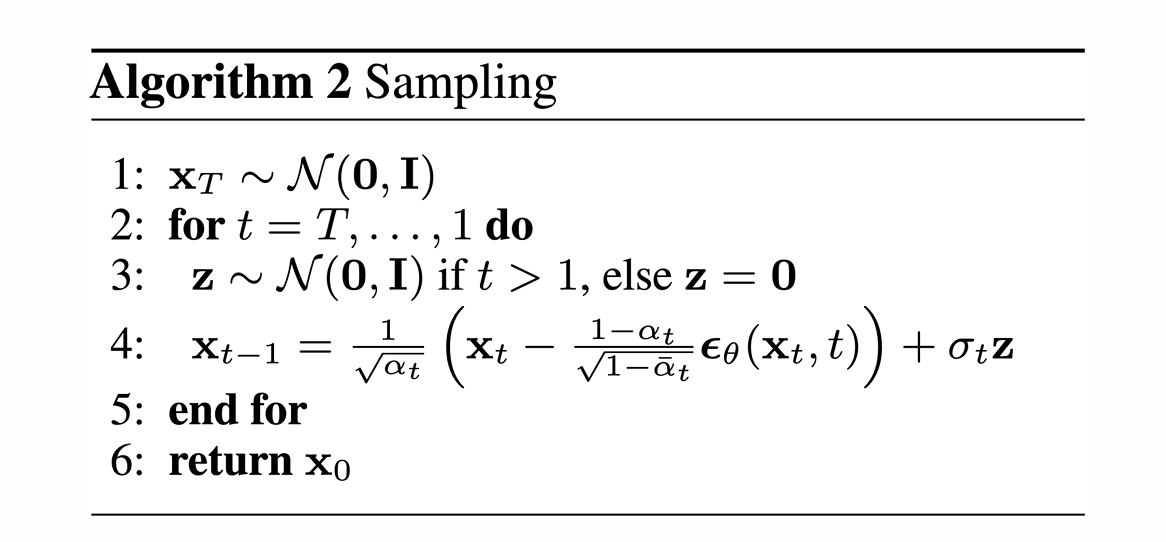

In [ ]:
import torch
import numpy as np

def generate_with_diffusion(model, y, latent_dim, scheduler):
    """
    Генерирует новый объект с помощью обученной диффузионной модели.

    model: обученная модель, предсказывающая шум ε_θ(x_t, t)
    y: условный вектор, форма (batch_size, y_dim)
    latent_dim: размерность латентного пространства 
    scheduler: объект DDPMScheduler (или аналог), управляющий процессом генерации
    """
    ### YOUR CODE IS HERE ######
    # Размер батча
    batch_size = y.shape[0]

    # Если y передаётся как нампай, конвертируем его в torch.Tensor
    if isinstance(y, np.ndarray):
        y = torch.tensor(y, dtype=torch.float32, device=DEVICE)

    # Инициализируем x_T случайным шумом из N(0, I)
    X_fake = torch.randn((batch_size, latent_dim), device=DEVICE)

    # Проходим по шагам диффузии в обратном порядке (T → 1)
    for t in tqdm.tqdm(scheduler.timesteps):
        # Создаём тензор текущего таймстепа t
        t_tensor = torch.tensor([t] * batch_size, device=DEVICE)
        # Предсказываем шум ε_θ(x_t, t)
        noise_pred = model(X_fake, t_tensor, y)
        # Делаем шаг назад по диффузии
        step_output = scheduler.step(noise_pred, t_tensor[0].item(), X_fake)
        # Обновляем X_fake (x_{t-1})
        X_fake = step_output.prev_sample
    ### THE END OF YOUR CODE ###
    return X_fake.detach().cpu().numpy()


У меня крашилось ядро, поэтому я разбил на батчи

In [ ]:
import torch
import numpy as np

def generate_with_diffusion_in_batches(model, y, latent_dim, scheduler, batch_size=50):
    """
    Разбивает генерацию на мини-батчи, чтобы уменьшить потребление памяти.
    """
    device = next(model.parameters()).device 
    num_samples = y.shape[0]
    X_fake_list = []
    
    for i in range(0, num_samples, batch_size):
        y_batch = y[i : min(i + batch_size, num_samples)] # Выбираем батч из y
        if isinstance(y_batch, np.ndarray): # Если y_batch - numpy массив, конвертируем его в torch.Tensor
            y_batch = torch.tensor(y_batch, dtype=torch.float32, device=device)

        if y_batch.shape[0] < batch_size: # Если размер батча меньше batch_size, дополняем его нулями
            padding = torch.zeros((batch_size - y_batch.shape[0], y_batch.shape[1]), device=device) 
            y_batch = torch.cat([y_batch, padding], dim=0)

        X_fake_batch = generate_with_diffusion(model, y_batch, latent_dim, scheduler) # Генерируем объекты для текущего батча
        X_fake_list.append(X_fake_batch) # Добавляем сгенерированные объекты в список

    return np.vstack(X_fake_list)  # Собираем все сгенерированные объекты


## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import tqdm

class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        scheduler=None
    ):
        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr

        self.scheduler = scheduler  # Сохраняем переданный scheduler

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.model.to(DEVICE)
    
    def fit(self, X, y):
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        dataset_real = TensorDataset(X_real, y_cond)

        self.model.train(True)
        self.loss_history = []

        # Число шагов диффузии (T=1000, например)
        num_timesteps = self.scheduler.config.num_train_timesteps

        for epoch in tqdm.tqdm(range(self.n_epochs)):
            loss_epoch = 0.0

            for real_batch, cond_batch in DataLoader(
                dataset_real, 
                batch_size=self.batch_size, 
                shuffle=True
            ):
                ### YOUR CODE IS HERE ######
                # 1) Сэмплируем случайный шаг t
                t = torch.randint(0, num_timesteps, (real_batch.size(0),), device=DEVICE)
                # 2) Генерируем шум
                noise = torch.randn_like(real_batch)
                # 3) Добавляем шум к реальным данным через scheduler.add_noise
                x_t = self.scheduler.add_noise(real_batch, noise, t)
                # 4) Прогоняем через модель (модель предсказывает шум)
                pred_noise = self.model(x_t, t, cond_batch)
                # 5) Считаем MSE лосс между предсказанным шумом и истинным
                loss = F.mse_loss(pred_noise, noise)
                # 6) Обновляем веса модели
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                loss_epoch += loss.item()

            # Средний лосс за эпоху
            self.loss_history.append(loss_epoch / len(dataset_real))

            #print(f"Epoch [{epoch+1}/{self.n_epochs}], Loss: {self.loss_history[-1]:.4f}")
            ### THE END OF YOUR CODE ###        
        self.model.train(False)


Обучим модель на данных, указав количество входов. 

У вас есть скрытое пространство и его размер, есть таймстепы и есть условие. Как легко догадаться, размер входа будет больше, чем просто размер скрытого пространства.

In [150]:
latent_dim = 10
scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)  # Создаём scheduler
model = DiffusionGenerator(n_inputs=latent_dim + 2, n_outputs=X_train_normal.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    scheduler=scheduler,  # Передаём scheduler
)

diffusionFitter.fit(X_train_normal, y_train)


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


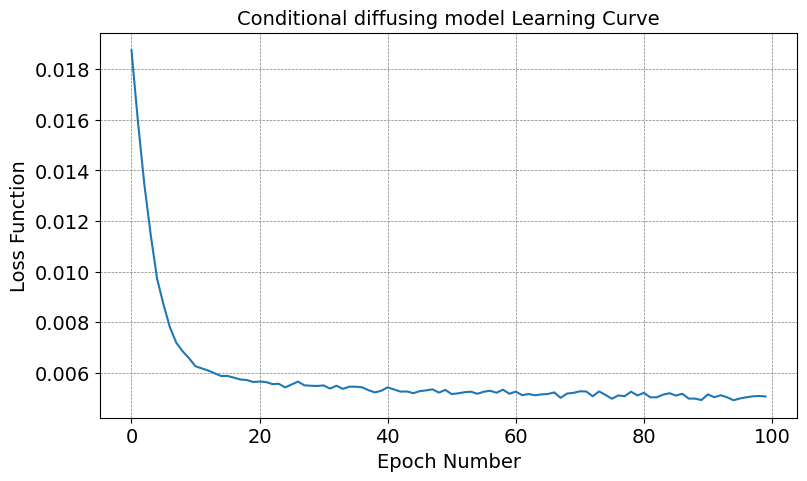

In [142]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [143]:
# как в 1 части
X_fake_train_DF = generate_with_diffusion_in_batches(model, y_train, latent_dim, scheduler) # Генерируем фейковые объекты
X_fake_train_DF = quantile_transformer.inverse_transform(X_fake_train_DF)

X_fake_test_DF = generate_with_diffusion_in_batches(model, y_test, latent_dim, scheduler)
X_fake_test_DF = quantile_transformer.inverse_transform(X_fake_test_DF)



100%|██████████| 1000/1000 [00:00<00:00, 1357.57it/s]


In [144]:
# собираем реальный и фейковые матрицы в одну
XX_train_DF = np.concatenate((X_fake_train_DF, X_train), axis=0) 
XX_test_DF = np.concatenate((X_fake_test_DF, X_test), axis=0)

yy_train_DF = np.array([0] * len(X_fake_train_DF) + [1] * len(X_train))
yy_test_DF = np.array([0] * len(X_fake_test_DF) + [1] * len(X_test))

from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf_DF = GradientBoostingClassifier()
clf_DF.fit(XX_train_DF, yy_train_DF)

# получаем прогнозы
yy_test_proba_DF = clf_DF.predict_proba(XX_test_DF)[:, 1]

from sklearn.metrics import roc_auc_score

auc_DF = roc_auc_score(yy_test_DF, yy_test_proba_DF)
print("ROC AUC = ", auc_DF)

ROC AUC =  0.760003534444316


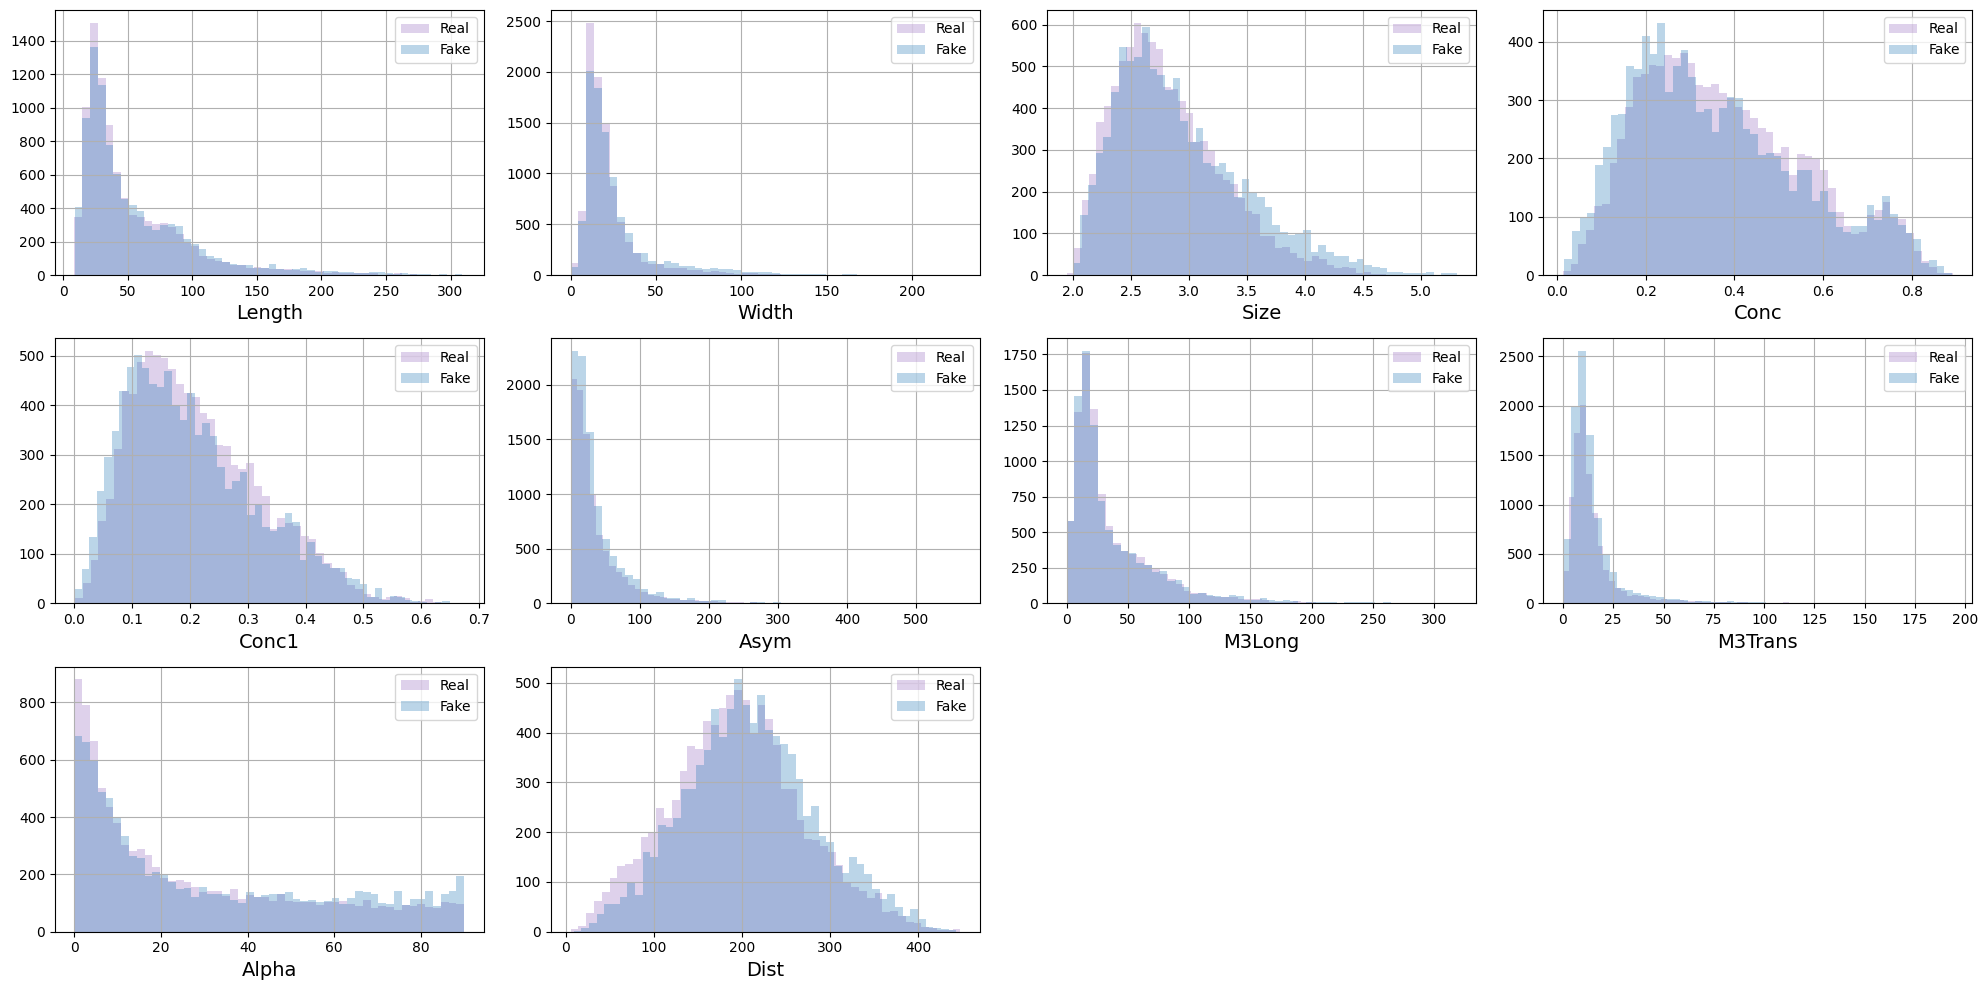

In [145]:
plot_hists(X_test, X_fake_test_DF, names, label1="Real", label2="Fake", bins=50)

> Получилось так себе. Я пытался менять архитектуру, но ничего путевого не получилось. Но результат в целом норм, но ожидалось большего

# Бонус (2 балла)

Кроме Diffusion и GAN вы изучили еще VAE и NF. В качестве бонуса релизуйте VAE, обучите, и в конце сравните качество теми же методами, что и в основной части ДЗ. 

Разбалловка бонуса такая:
- Реализовать VAE - 1 балл
- Обучить VAE - 0.5 балла
- Провести сравнение с GAN и Diffusion аналогично 14 заданию основной части - 0.5 балла

Ниже приведены шаблоны. Они не особо щедры на комментарии, но поскольку задача бонусная, ожидаем, что вы в них разберетесь. Если они вам не нравятся - можете переписать как хотите.

Если же VAE вам кажется слишком скучным, то мы засчитаем реализацию NF, но шаблонов не предоставим. Бонус в таком случае тоже ограничен сверху 2 баллами и разбалловка не изменится.

In [1]:
import torch
import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, lat_size)
        self.log_sigma = nn.Linear(32, lat_size) 
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1) # Склеиваем x и y
        z = self.enc_net(z) # Пропускаем через сеть
        mu = self.mu(z) # Получаем mu
        log_sigma = self.log_sigma(z) # Получаем log_sigma
        return mu, log_sigma



class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec
    
def generate(decoder, y, latent_dim): # как в WGAN части
    ### YOUR CODE IS HERE ######
    z = torch.normal(mean=0, std=1, size=(y.shape[0], latent_dim), device=DEVICE)
    y_tensor = torch.tensor(y, dtype=torch.float, device=DEVICE) 
    with torch.no_grad():
        X_fake = decoder(z, y_tensor).detach().cpu().numpy()
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

In [2]:
import tqdm
class VAEFitter(object):
    def __init__(
        self,
        encoder,
        decoder,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        KL_weight=0.001,
    ):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt = torch.optim.RMSprop(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=self.lr,
        )

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1), dim=0
        )
        recon_loss = self.criterion(x, rec_x)
        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x_batch, cond_batch):

        ### YOUR CODE IS HERE ######
        mu, log_sigma = self.encoder(x_batch, cond_batch) # Получаем mu и log_sigma
        z = self.sample_z(mu, log_sigma) # Сэмплируем z
        x_rec = self.decoder(z, cond_batch) # Получаем реконструкцию
        loss = self.custom_loss(x_batch, x_rec, mu, log_sigma) # Считаем лосс
        ### THE END OF YOUR CODE ###

        return loss

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True) 
        self.decoder.train(True)

        self.loss_history = []

        # Fit
        for epoch in tqdm.tqdm(range(self.n_epochs)): # Итерируемся по эпохам
            for i, (x_batch, cond_batch) in enumerate( # Итерируемся по батчам 
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad() # Обнуляем градиенты
                loss.backward() # Считаем градиенты
                self.opt.step() # Делаем шаг оптимизации

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond) # Считаем лосс на всей выборке
            self.loss_history.append(loss_epoch.detach().cpu()) # Сохраняем лосс

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

In [21]:
%%time
# Training setup
latent_dim = 10
encoder = Encoder(n_inputs=X_train_normal.shape[1] + y_train.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim + y_train.shape[1], n_outputs=X_train_normal.shape[1])

vae_fitter = VAEFitter(
    encoder,
    decoder,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    KL_weight=0.001,
)
vae_fitter.fit(X_train_normal, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:05<00:00,  1.25s/it]

CPU times: total: 6min 32s
Wall time: 2min 5s


In [22]:
# как в 1 части
X_fake_train_VAE = generate(vae_fitter.decoder, y_train, latent_dim) # Генерируем фейковые объекты
X_fake_train_VAE = quantile_transformer.inverse_transform(X_fake_train_VAE)

X_fake_test_VAE = generate(vae_fitter.decoder, y_test, latent_dim)
X_fake_test_VAE = quantile_transformer.inverse_transform(X_fake_test_VAE)

# собираем реальный и фейковые матрицы в одну
XX_train_VAE = np.concatenate((X_fake_train_VAE, X_train), axis=0) 
XX_test_VAE = np.concatenate((X_fake_test_VAE, X_test), axis=0)

yy_train_VAE = np.array([0] * len(X_fake_train_VAE) + [1] * len(X_train))
yy_test_VAE = np.array([0] * len(X_fake_test_VAE) + [1] * len(X_test))

from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf_VAE = GradientBoostingClassifier()
clf_VAE.fit(XX_train_VAE, yy_train_VAE)

# получаем прогнозы
yy_test_proba_VAE = clf_VAE.predict_proba(XX_test_VAE)[:, 1]

from sklearn.metrics import roc_auc_score

auc_VAE = roc_auc_score(yy_test_VAE, yy_test_proba_VAE)
print("ROC AUC = ", auc_VAE)

ROC AUC =  0.8856367971729354


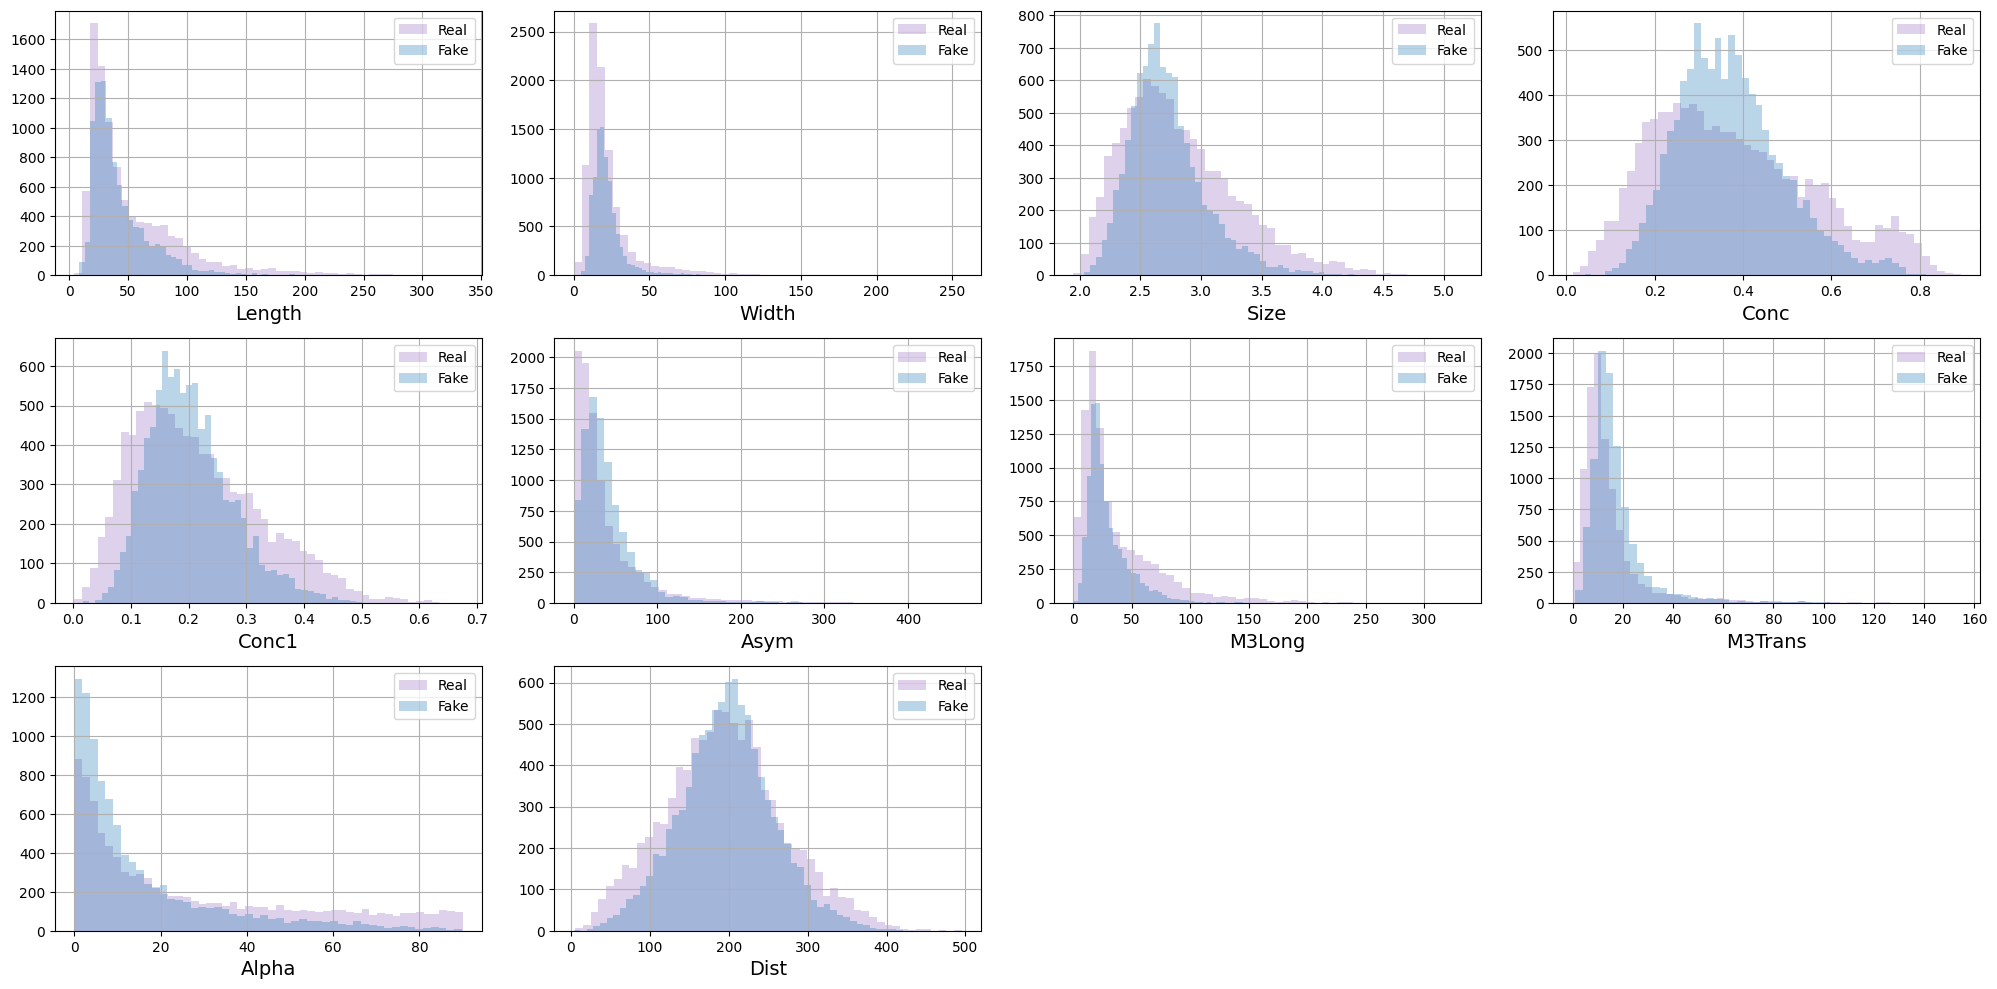

In [23]:
plot_hists(X_test, X_fake_test_VAE, names, label1="Real", label2="Fake", bins=50)

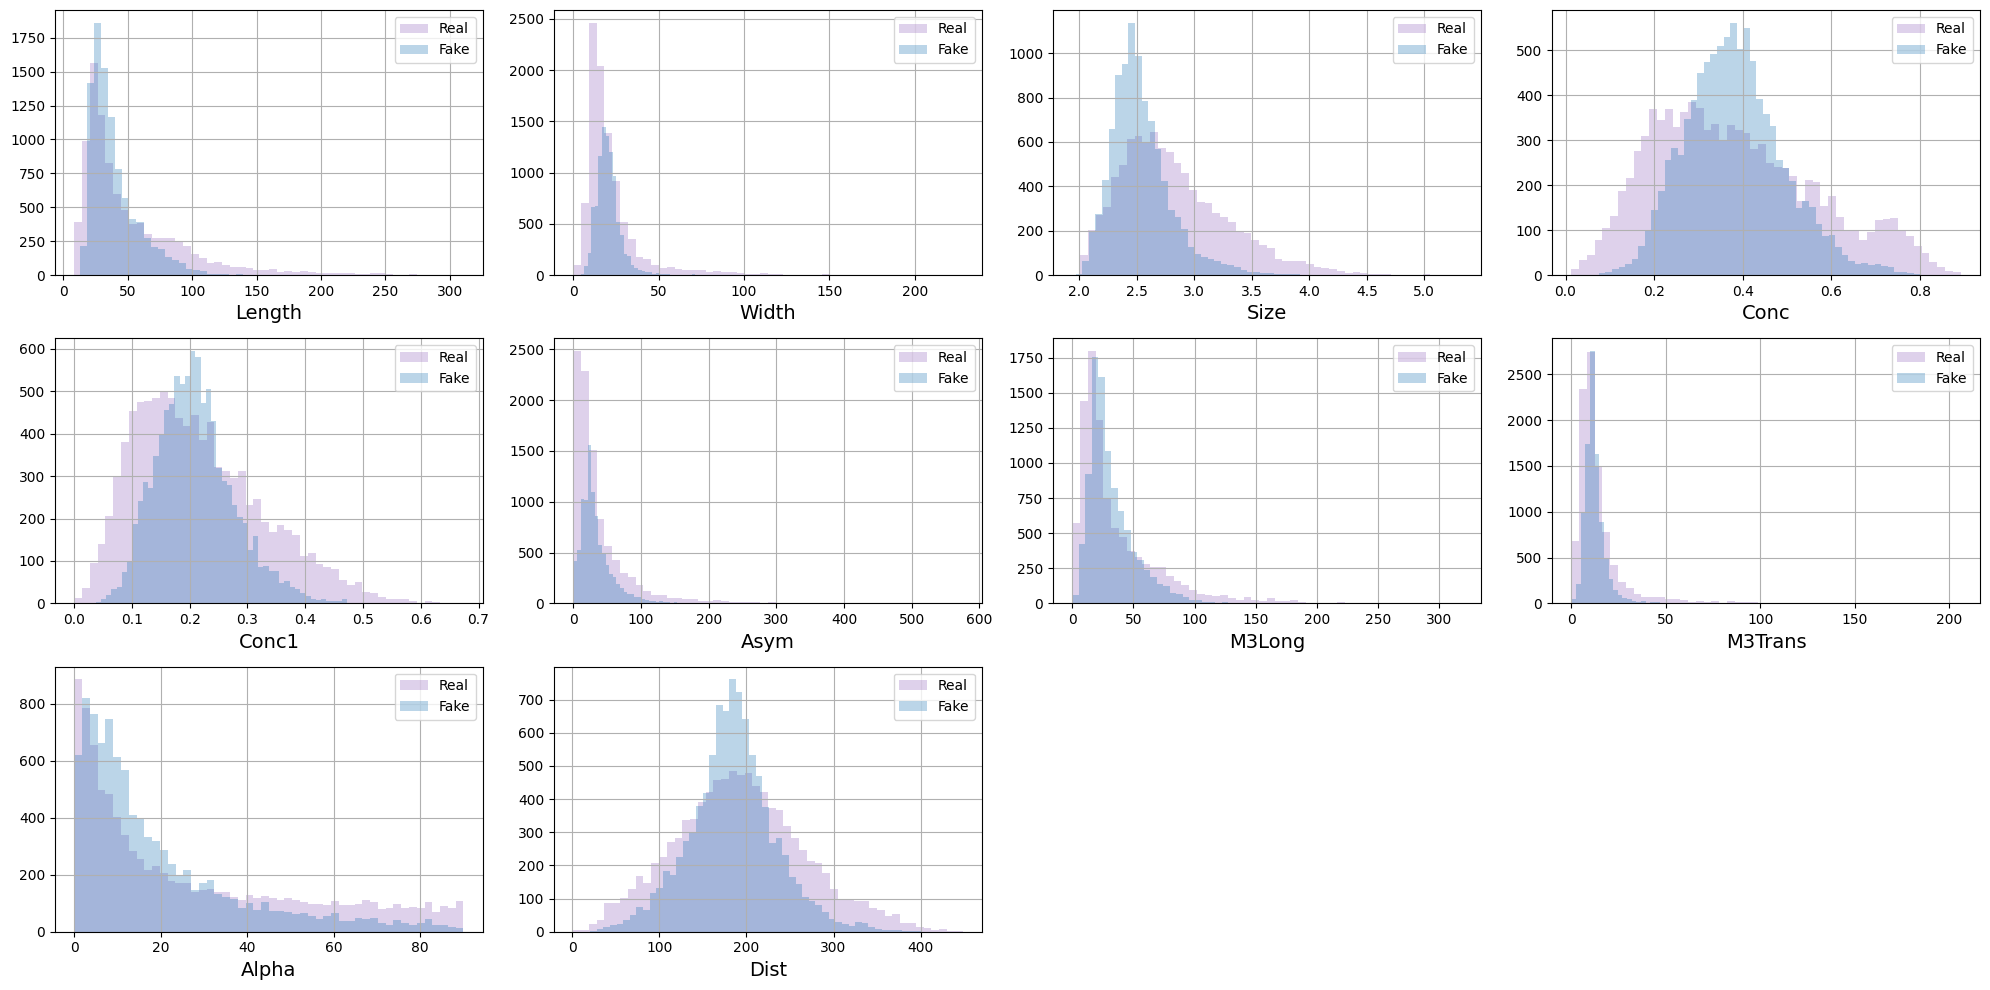

In [239]:
plot_hists(X_train, X_fake_train_VAE, names, label1="Real", label2="Fake", bins=50)

Трешак

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

In [ ]:
Мне не понравился сем